In [ ]:
#Импорт библиотек
import pandas as pd

import numpy as np

import tensorflow as tf

import pandas as pd

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D

from tensorflow.keras import utils

from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, RMSprop

from tensorflow.keras.preprocessing.text import Tokenizer

from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping , ModelCheckpoint

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Загружаем датасет с переменную
dt_wearout = pd.read_excel('/content/РЖД.xlsx', sheet_name='Износ')
dt_wearout.head(10)

,Н_Ло,Н_КП,Н_Се,Номер,Секция,Н_серии,Начало,Конец,Период,Износ,Толщина гребня на начало,Толщина гребня на конец,Пробег за период,Пробег на начало,Пробег на конец
0,4573,81329,18728,2,1,253,2022-01-25,2022-12-08,317,3.00,32.00,29.00,133132.0,1873288.0,2006420.0
1,4573,114993,18728,2,1,253,2022-01-25,2022-12-08,317,3.00,32.00,29.00,133132.0,1873288.0,2006420.0
2,4573,82697,18728,2,1,253,2022-01-25,2022-07-04,160,1.20,31.25,30.05,66482.0,1873288.0,1939770.0
3,4573,82697,18728,2,1,253,2022-07-05,2022-12-08,156,2.00,31.50,29.50,66650.0,1939770.0,2006420.0
4,4573,117134,18728,2,1,253,2022-01-25,2022-07-04,160,0.50,31.00,30.50,66482.0,1873288.0,1939770.0
5,4573,117134,18728,2,1,253,2022-07-05,2022-12-08,156,3.50,31.50,28.00,66650.0,1939770.0,2006420.0
6,4573,117376,23439,2,2,253,2022-01-25,2022-11-10,289,1.50,30.75,29.25,120438.0,1873288.0,1993726.0
7,4573,117376,23439,2,2,253,2022-11-11,2022-12-08,27,0.00,29.25,29.25,12694.0,1993726.0,2006420.0
8,4573,81104,23439,2,2,253,2022-01-25,2022-11-10,289,1.75,31.25,29.50,120438.0,1873288.0,1993726.0
9,4573,81104,23439,2,2,253,2022-11-11,2022-12-08,27,0.00,30.75,30.75,12694.0,1993726.0,2006420.0


In [ ]:
# удалим пропуски датасета Износ
dt_wearout = dt_wearout.dropna().reset_index(drop=True)
dt_wearout = dt_wearout[dt_wearout['Износ']<10]
# заменим данные столбца "Пробег за период" на значение разницы столбцов 'Пробег на конец' и 'Пробег на начало'
dt_wearout['Пробег за период'] = dt_wearout['Пробег на конец'] - dt_wearout['Пробег на начало']

In [ ]:
dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1)

,Секция,Н_серии,Период,Износ,Пробег за период
0,1,253,317,3.00,133132.0
1,1,253,317,3.00,133132.0
2,1,253,160,1.20,66482.0
3,1,253,156,2.00,66650.0
4,1,253,160,0.50,66482.0
...,...,...,...,...,...
82280,2,222,82,1.00,40319.0
82281,2,222,80,0.50,40657.0
82282,2,222,82,1.00,40319.0
82283,2,222,80,1.25,40657.0


In [ ]:
# построим матрицу корреляции
dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1).corr().style.background_gradient(cmap='coolwarm')

,Секция,Н_серии,Период,Износ,Пробег за период
Секция,1.000000,-0.110575,0.000994,0.039188,0.057922
Н_серии,-0.110575,1.000000,-0.012746,0.015267,-0.157611
Период,0.000994,-0.012746,1.000000,0.527819,0.910826
Износ,0.039188,0.015267,0.527819,1.000000,0.555292
Пробег за период,0.057922,-0.157611,0.910826,0.555292,1.000000


In [ ]:
# преобразуем категориальные данные и построим матрицу корреляции
pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=['Секция',	'Н_серии'])

,Период,Износ,Пробег за период,Секция_1,Секция_2,Секция_3,Н_серии_222,Н_серии_253,Н_серии_640
0,317,3.00,133132.0,1,0,0,0,1,0
1,317,3.00,133132.0,1,0,0,0,1,0
2,160,1.20,66482.0,1,0,0,0,1,0
3,156,2.00,66650.0,1,0,0,0,1,0
4,160,0.50,66482.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
82280,82,1.00,40319.0,0,1,0,1,0,0
82281,80,0.50,40657.0,0,1,0,1,0,0
82282,82,1.00,40319.0,0,1,0,1,0,0
82283,80,1.25,40657.0,0,1,0,1,0,0


In [ ]:
pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=['Секция',	'Н_серии']).corr().style.background_gradient(cmap='coolwarm')

,Период,Износ,Пробег за период,Секция_1,Секция_2,Секция_3,Н_серии_222,Н_серии_253,Н_серии_640
Период,1.000000,0.527819,0.910826,-0.002681,0.003946,-0.001753,0.006636,0.002908,-0.012584
Износ,0.527819,1.000000,0.555292,-0.017558,-0.020830,0.053322,-0.124123,0.119539,0.002877
Пробег за период,0.910826,0.555292,1.000000,-0.029124,-0.024439,0.074406,-0.040718,0.165978,-0.168490
Секция_1,-0.002681,-0.017558,-0.029124,1.000000,-0.740870,-0.360748,0.116811,-0.165169,0.067695
Секция_2,0.003946,-0.020830,-0.024439,-0.740870,1.000000,-0.359155,0.122998,-0.170353,0.066517
Секция_3,-0.001753,0.053322,0.074406,-0.360748,-0.359155,1.000000,-0.333110,0.466064,-0.186430
Н_серии_222,0.006636,-0.124123,-0.040718,0.116811,0.122998,-0.333110,1.000000,-0.714731,-0.355108
Н_серии_253,0.002908,0.119539,0.165978,-0.165169,-0.170353,0.466064,-0.714731,1.000000,-0.400010
Н_серии_640,-0.012584,0.002877,-0.168490,0.067695,0.066517,-0.186430,-0.355108,-0.400010,1.000000


In [ ]:
# выведем новое представление закодированной категориальной части
pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                'Конец', 'Толщина гребня на начало',
                                'Толщина гребня на конец', 'Пробег на начало',
                                'Пробег на конец'], axis=1), columns=\
                                ['Секция',	'Н_серии']).drop(['Период','Износ',
                                                              'Пробег за период'],
                                                             axis=1).values.astype(int)

array([[1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0]])

In [ ]:
# создадим функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 10.):

    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения Износа')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

In [ ]:
# создадим функцию для вывода графиков средней абсолютной ошибки на обучающем и проверочном наборе
def plot_history(history):
    plt.plot(history.history['mae'],
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'],
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

In [ ]:
# создадим выборки данных
x_data_num = pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=\
                                   ['Секция','Н_серии'])[['Период',
                                                          'Пробег за период']].values
x_data_cat = pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                'Конец', 'Толщина гребня на начало',
                                'Толщина гребня на конец', 'Пробег на начало',
                                'Пробег на конец'], axis=1), columns=\
                                ['Секция',	'Н_серии']).drop(['Период','Износ',
                                                              'Пробег за период'],
                                                             axis=1).values.astype(int)
y_data = pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=\
                                   ['Секция',	'Н_серии'])['Износ'].values

In [ ]:
# выведем размер выборок
print(x_data_num.shape)
print(x_data_cat.shape)
print(y_data.shape)

(82284, 2)
(82284, 6)
(82284,)


# Числовые данные

In [ ]:
# нормируем числовые данные
x_scaler = StandardScaler()
x_num_scaled = x_scaler.fit_transform(x_data_num)

y_scaler = StandardScaler()
y_scaled = y_data.reshape(-1,1)
y_scaled = y_scaler.fit_transform(y_scaled)

print('Размер нормализованных числовых данных обучающей выборки', x_num_scaled.shape)
print('Размер нормализованных правильных ответов', y_scaled.shape)

Размер нормализованных числовых данных обучающей выборки (82284, 2)
Размер нормализованных правильных ответов (82284, 1)


In [ ]:
# разобъем числовую выборку на обучающую и тестовую
x_train_num, x_test_num, y_train_num, y_test_num = train_test_split(x_num_scaled,y_scaled,test_size=0.2,shuffle = False)
print(x_train_num.shape)
print(y_train_num.shape)
print(x_test_num.shape)
print(y_test_num.shape)

(65827, 2)
(65827, 1)
(16457, 2)
(16457, 1)


Epoch 1/30
219/219 [==============================] - 5s 16ms/step - loss: 0.7235 - mae: 0.6629 - val_loss: 0.5488 - val_mae: 0.5857
Epoch 2/30
219/219 [==============================] - 3s 16ms/step - loss: 0.7075 - mae: 0.6566 - val_loss: 0.5384 - val_mae: 0.5720
Epoch 3/30
219/219 [==============================] - 4s 20ms/step - loss: 0.7050 - mae: 0.6557 - val_loss: 0.5535 - val_mae: 0.5824
Epoch 4/30
219/219 [==============================] - 5s 21ms/step - loss: 0.7034 - mae: 0.6550 - val_loss: 0.5461 - val_mae: 0.5795
Epoch 5/30
219/219 [==============================] - 3s 16ms/step - loss: 0.7022 - mae: 0.6543 - val_loss: 0.5761 - val_mae: 0.5921
Epoch 6/30
219/219 [==============================] - 5s 21ms/step - loss: 0.7023 - mae: 0.6545 - val_loss: 0.5667 - val_mae: 0.5955
Epoch 7/30
219/219 [==============================] - 3s 16ms/step - loss: 0.7028 - mae: 0.6545 - val_loss: 0.5742 - val_mae: 0.6015
Epoch 8/30
219/219 [==============================] - 3s 16ms/step - 

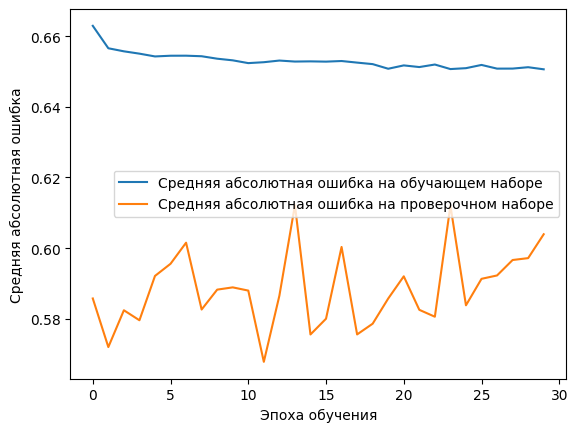

In [ ]:
# Обучение модели на числовых данных

model_num = Sequential()
model_num.add(BatchNormalization(input_dim=x_train_num.shape[1]))
model_num.add(Dense(128, activation='relu'))
model_num.add(Dense(1000, activation='relu'))
model_num.add(Dropout(0.2))
model_num.add(Dense(100, activation='relu'))
model_num.add(Dense(1, activation='linear'))

model_num.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history_num = model_num.fit(x_train_num,
                    y_train_num,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1)

plot_history(history_num)

2058/2058 [==============================] - 5s 2ms/step
Средняя абсолютная ошибка: 1.936188653999386 

Реальное значение:   0.89  Предсказанное значение:   2.75  Разница:   1.87
Реальное значение:   0.89  Предсказанное значение:   2.75  Разница:   1.87
Реальное значение:  -0.44  Предсказанное значение:   2.35  Разница:   2.79
Реальное значение:   0.15  Предсказанное значение:   2.23  Разница:   2.08
Реальное значение:  -0.96  Предсказанное значение:   2.35  Разница:   3.30
Реальное значение:   1.26  Предсказанное значение:   2.23  Разница:   0.98
Реальное значение:  -0.22  Предсказанное значение:   2.82  Разница:   3.04
Реальное значение:  -1.32  Предсказанное значение:   0.70  Разница:   2.02
Реальное значение:  -0.03  Предсказанное значение:   2.82  Разница:   2.85
Реальное значение:  -1.32  Предсказанное значение:   0.70  Разница:   2.02


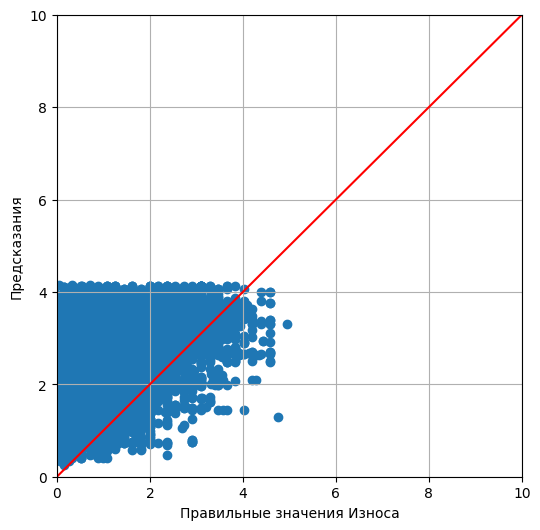

In [ ]:
eval_net(model_num, x_train_num, y_train_num, y_scaler)

In [ ]:
# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size, y_size):
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'],
         label='Ошибка на обучающей выборке')
  plt.plot(history.history['val_loss'],
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

# Категориальные данные

In [ ]:
# разобъем категориальную выборку на обучающую и тестовую
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_data_cat,y_scaled,test_size=0.2,shuffle = False)
print(x_train_cat.shape)
print(y_train_cat.shape)
print(x_test_cat.shape)
print(y_test_cat.shape)

(65827, 6)
(65827, 1)
(16457, 6)
(16457, 1)


Epoch 1/30
219/219 [==============================] - 4s 14ms/step - loss: 1.0856 - mae: 0.8465 - val_loss: 0.7657 - val_mae: 0.7142
Epoch 2/30
219/219 [==============================] - 3s 13ms/step - loss: 1.0855 - mae: 0.8462 - val_loss: 0.7644 - val_mae: 0.7129
Epoch 3/30
219/219 [==============================] - 5s 22ms/step - loss: 1.0850 - mae: 0.8458 - val_loss: 0.7623 - val_mae: 0.7073
Epoch 4/30
219/219 [==============================] - 5s 23ms/step - loss: 1.0848 - mae: 0.8456 - val_loss: 0.7809 - val_mae: 0.7253
Epoch 5/30
219/219 [==============================] - 3s 14ms/step - loss: 1.0846 - mae: 0.8458 - val_loss: 0.7654 - val_mae: 0.7141
Epoch 6/30
219/219 [==============================] - 4s 17ms/step - loss: 1.0844 - mae: 0.8456 - val_loss: 0.7614 - val_mae: 0.7098
Epoch 7/30
219/219 [==============================] - 3s 15ms/step - loss: 1.0846 - mae: 0.8456 - val_loss: 0.7655 - val_mae: 0.7120
Epoch 8/30
219/219 [==============================] - 4s 17ms/step - 

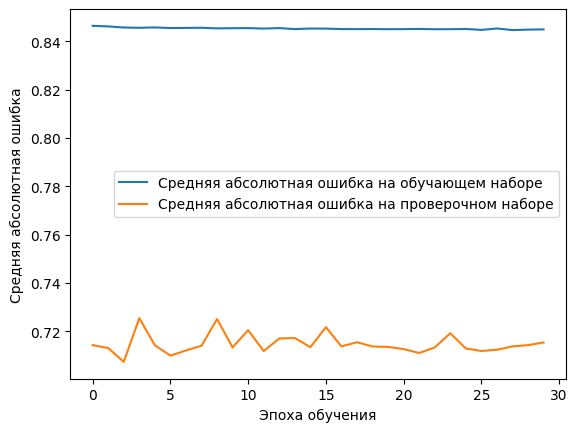

In [ ]:
# Обучение модели на категориальных данных

model_cat = Sequential()
model_cat.add(BatchNormalization(input_dim=x_train_cat.shape[1]))
model_cat.add(Dense(128, activation='relu'))
model_cat.add(Dense(1000, activation='relu'))
model_cat.add(Dense(100, activation='relu'))
model_cat.add(Dense(1, activation='linear'))

model_cat.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history_cat = model_cat.fit(x_train_cat,
                    y_train_cat,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1)

plot_history(history_cat)

2058/2058 [==============================] - 6s 3ms/step
Средняя абсолютная ошибка: 1.8911892104218084 

Реальное значение:   0.89  Предсказанное значение:   1.97  Разница:   1.08
Реальное значение:   0.89  Предсказанное значение:   1.97  Разница:   1.08
Реальное значение:  -0.44  Предсказанное значение:   1.97  Разница:   2.41
Реальное значение:   0.15  Предсказанное значение:   1.97  Разница:   1.82
Реальное значение:  -0.96  Предсказанное значение:   1.97  Разница:   2.93
Реальное значение:   1.26  Предсказанное значение:   1.97  Разница:   0.71
Реальное значение:  -0.22  Предсказанное значение:   1.95  Разница:   2.17
Реальное значение:  -1.32  Предсказанное значение:   1.95  Разница:   3.28
Реальное значение:  -0.03  Предсказанное значение:   1.95  Разница:   1.99
Реальное значение:  -1.32  Предсказанное значение:   1.95  Разница:   3.28


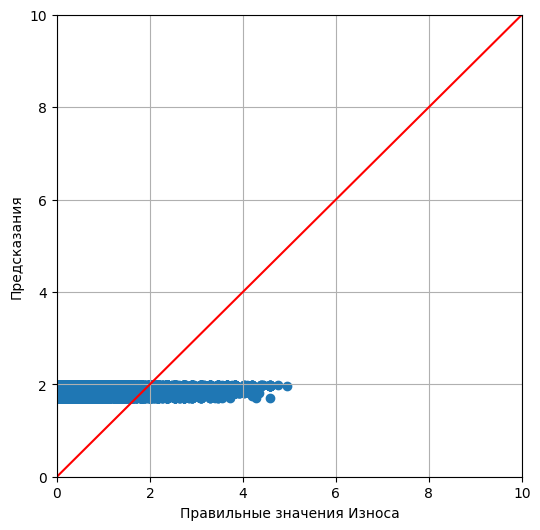

In [ ]:
eval_net(model_cat, x_train_cat, y_train_cat, y_scaler)

# FunctionalAPI

In [ ]:
# построим FunctionalAPI

input1 = Input((x_train_num.shape[1],))
input2 = Input((x_train_cat.shape[1],))

x1 = input1                               # Ветка числовых данных
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="elu")(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка категориальных данных
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(500, activation="tanh")(x2)
x2 = Dropout(0.3)(x2)

x = concatenate([x1, x2])             # Объединение веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_func = Model((input1, input2), x)

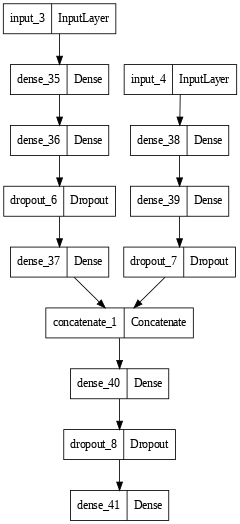

In [ ]:
# выведем схему построения модели
utils.plot_model(model_func, dpi=60)

In [ ]:
model_func.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 dense_35 (Dense)            (None, 128)                  384       ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 dense_36 (Dense)            (None, 1000)                 129000    ['dense_35[0][0]']            
                                                                                            

Epoch 1/50
274/274 [==============================] - 9s 25ms/step - loss: 0.7266 - mae: 0.6664 - val_loss: 0.5211 - val_mae: 0.5638
Epoch 2/50
274/274 [==============================] - 6s 21ms/step - loss: 0.7020 - mae: 0.6564 - val_loss: 0.5250 - val_mae: 0.5579
Epoch 3/50
274/274 [==============================] - 6s 22ms/step - loss: 0.6971 - mae: 0.6535 - val_loss: 0.5204 - val_mae: 0.5624
Epoch 4/50
274/274 [==============================] - 5s 19ms/step - loss: 0.6984 - mae: 0.6551 - val_loss: 0.5202 - val_mae: 0.5633
Epoch 5/50
274/274 [==============================] - 6s 23ms/step - loss: 0.6952 - mae: 0.6534 - val_loss: 0.5272 - val_mae: 0.5708
Epoch 6/50
274/274 [==============================] - 5s 19ms/step - loss: 0.6947 - mae: 0.6524 - val_loss: 0.5220 - val_mae: 0.5619
Epoch 7/50
274/274 [==============================] - 6s 23ms/step - loss: 0.6934 - mae: 0.6513 - val_loss: 0.5185 - val_mae: 0.5555
Epoch 8/50
274/274 [==============================] - 5s 19ms/step - 

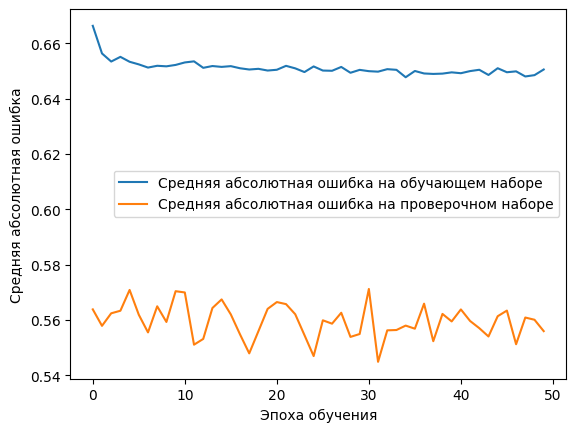

In [ ]:
model_func.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history_func = model_func.fit([x_num_scaled, x_data_cat],
                           y_scaled,
                           batch_size=256,
                           epochs=50,
                           validation_split=0.15,
                           verbose=1)
plot_history(history_func)

2572/2572 [==============================] - 8s 3ms/step
Средняя абсолютная ошибка: 0.8332669153732764 

Реальное значение:   3.00  Предсказанное значение:   2.64  Разница:   0.36
Реальное значение:   3.00  Предсказанное значение:   2.64  Разница:   0.36
Реальное значение:   1.20  Предсказанное значение:   2.18  Разница:   0.98
Реальное значение:   2.00  Предсказанное значение:   2.17  Разница:   0.17
Реальное значение:   0.50  Предсказанное значение:   2.18  Разница:   1.68
Реальное значение:   3.50  Предсказанное значение:   2.17  Разница:   1.33
Реальное значение:   1.50  Предсказанное значение:   2.55  Разница:   1.05
Реальное значение:   0.00  Предсказанное значение:   0.83  Разница:   0.83
Реальное значение:   1.75  Предсказанное значение:   2.55  Разница:   0.80
Реальное значение:   0.00  Предсказанное значение:   0.83  Разница:   0.83


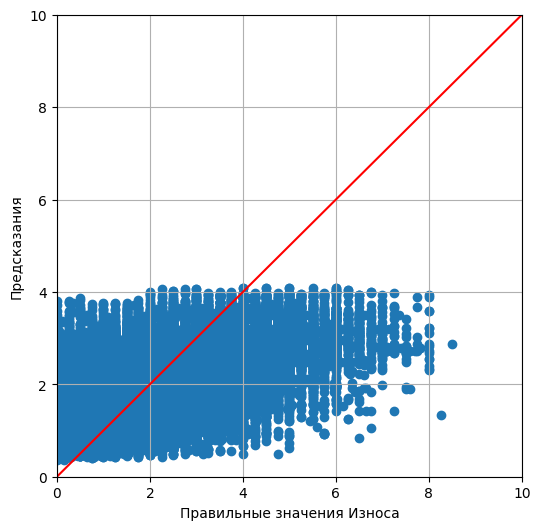

In [ ]:
eval_net(model_func, [x_num_scaled, x_data_cat], y_data.reshape(-1,1), y_scaler)